# Notebook 5: Inference

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import json

# Import models from previous notebook
import torchvision.models as models
import timm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0
CUDA available: False


In [2]:
# Paths
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
MODELS_DIR = OUTPUT_DIR / "models"

# Test data
TEST_FEATURES_CSV = DATA_DIR / "test_features.csv"

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class names (MUST be in this order for submission)
CLASS_COLUMNS = [
    'antelope_duiker', 'bird', 'blank', 'civet_genet',
    'hog', 'leopard', 'monkey_prosimian', 'rodent'
]

# Settings
IMG_SIZE = 192
BATCH_SIZE = 256  # Larger for inference (no gradients)

print(f"Device: {DEVICE}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Device: cpu
Image size: 192
Batch size: 256


In [3]:
class ResNet50Model(nn.Module):
    """ResNet50 with custom classifier"""
    
    def __init__(self, num_classes=8, pretrained=True, dropout=0.5):
        super(ResNet50Model, self).__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )
        self.model_name = "ResNet50"
    
    def forward(self, x):
        return self.backbone(x)


class EfficientNetModel(nn.Module):
    """EfficientNet with custom classifier"""
    
    def __init__(self, model_name='efficientnet_b0', num_classes=8, pretrained=True, dropout=0.5):
        super(EfficientNetModel, self).__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes,
            drop_rate=dropout
        )
        self.model_name = model_name
    
    def forward(self, x):
        return self.backbone(x)


def create_model(model_type='resnet50', num_classes=8):
    """Create model architecture"""
    if model_type == 'resnet50':
        model = ResNet50Model(num_classes, pretrained=False, dropout=0.5)
    elif model_type.startswith('efficientnet'):
        model = EfficientNetModel(model_type, num_classes, pretrained=False, dropout=0.5)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    return model

print(" Model architectures defined")

 Model architectures defined


In [4]:
def load_checkpoint(checkpoint_path, model_type='resnet50', device='cuda'):
    """Load trained model from checkpoint"""
    
    print(f"Loading checkpoint: {checkpoint_path}")
    
    # Create model
    model = create_model(model_type=model_type, num_classes=8)
    
    # Load weights
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"✓ Model loaded successfully")
    if 'val_log_loss' in checkpoint:
        print(f"   Validation LogLoss: {checkpoint['val_log_loss']:.4f}")
    if 'epoch' in checkpoint:
        print(f"   Epoch: {checkpoint['epoch']}")
    
    return model

# List available checkpoints
print("Available checkpoints:")
checkpoints = list(MODELS_DIR.glob("*_best.pth"))
for i, ckpt in enumerate(checkpoints, 1):
    print(f"   {i}. {ckpt.name}")

# Automatically pick the latest best checkpoint
best_checkpoints = sorted(
    MODELS_DIR.glob("*_best.pth"),
    key=lambda x: x.stat().st_mtime
)

if len(best_checkpoints) == 0:
    raise FileNotFoundError("No *_best.pth checkpoint found in models directory")

CHECKPOINT_PATH = best_checkpoints[-1]
print(f"Using checkpoint: {CHECKPOINT_PATH.name}")


# Load model
model = load_checkpoint(CHECKPOINT_PATH, model_type='resnet50', device=DEVICE)

Available checkpoints:
   1. resnet50_baseline_0120_1316_best.pth
   2. resnet50_baseline_0121_1154_best.pth
Using checkpoint: resnet50_baseline_0121_1154_best.pth
Loading checkpoint: outputs/models/resnet50_baseline_0121_1154_best.pth


/Users/gurjindersingh/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gurjindersingh/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Model loaded successfully
   Validation LogLoss: 1.6188
   Epoch: 2


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_test_transforms(img_size=224):
    """Test transforms - no augmentation"""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

test_transform = get_test_transforms(IMG_SIZE)
print(" Test transforms created")

 Test transforms created


In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TestDataset(Dataset):
    """Dataset for test images"""
    
    def __init__(self, df, data_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = Path(data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['filepath']
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return {
            'image': image,
            'image_id': row['id']
        }

# Load test data
test_df = pd.read_csv(TEST_FEATURES_CSV)
print(f" Test data: {len(test_df)} images")

# Create dataset and dataloader
test_dataset = TestDataset(
    df=test_df,
    data_dir=DATA_DIR,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f" Test loader: {len(test_loader)} batches")

 Test data: 4464 images
 Test loader: 18 batches


In [7]:
def generate_predictions(model, test_loader, device):
    """Generate predictions for all test images"""
    
    model.eval()
    all_predictions = []
    all_ids = []
    
    print("Generating predictions...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            images = batch['image'].to(device)
            image_ids = batch['image_id']
            
            # Forward pass
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            
            all_predictions.append(probs.cpu().numpy())
            all_ids.extend(image_ids)
    
    # Concatenate all predictions
    all_predictions = np.vstack(all_predictions)
    
    print(f" Generated predictions for {len(all_ids)} images")
    print(f"   Prediction shape: {all_predictions.shape}")
    
    return all_predictions, all_ids

# Generate predictions
predictions, image_ids = generate_predictions(model, test_loader, DEVICE)

Generating predictions...


Predicting:   0%|          | 0/18 [00:00<?, ?it/s]

 Generated predictions for 4464 images
   Prediction shape: (4464, 8)


In [8]:
# Create predictions dataframe
submission_df = pd.DataFrame(predictions, columns=CLASS_COLUMNS)
submission_df.insert(0, 'id', image_ids)

print(" Submission dataframe created")
print(f"   Shape: {submission_df.shape}")
print("\nFirst few rows:")
display(submission_df.head())

 Submission dataframe created
   Shape: (4464, 9)

First few rows:


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.021531,0.001420,0.025111,0.831887,0.012882,0.029937,0.001459,0.075773
1,ZJ016489,0.490976,0.010221,0.021238,0.004270,0.057012,0.041395,0.252599,0.122290
2,ZJ016490,0.603275,0.003062,0.058545,0.086709,0.054814,0.021288,0.094183,0.078124
3,ZJ016491,0.003049,0.000268,0.001632,0.001011,0.004418,0.986715,0.001307,0.001600
4,ZJ016492,0.387639,0.040864,0.014033,0.004398,0.003852,0.005060,0.517902,0.026253


In [9]:
def validate_submission(df):
    """Validate submission format"""
    
    print("Validating submission...")
    
    issues = []
    
    # Check columns
    expected_cols = ['id'] + CLASS_COLUMNS
    if list(df.columns) != expected_cols:
        issues.append(f"Column mismatch. Expected: {expected_cols}")
    
    # Check for missing values
    if df.isnull().any().any():
        issues.append("Contains missing values")
    
    # Check probabilities are in valid range
    prob_cols = CLASS_COLUMNS
    if (df[prob_cols] < 0).any().any() or (df[prob_cols] > 1).any().any():
        issues.append("Probabilities outside [0, 1] range")
    
    # Check row sums
    row_sums = df[prob_cols].sum(axis=1)
    if not np.allclose(row_sums, 1.0, atol=1e-4):
        issues.append(f"Row sums not equal to 1.0. Range: [{row_sums.min():.6f}, {row_sums.max():.6f}]")
    
    # Check number of rows
    if len(df) != len(test_df):
        issues.append(f"Row count mismatch. Expected: {len(test_df)}, Got: {len(df)}")
    
    if issues:
        print(" Validation FAILED:")
        for issue in issues:
            print(f"   • {issue}")
        return False
    else:
        print(" Validation PASSED!")
        print(f"   • {len(df)} predictions")
        print(f"   • All probabilities in [0, 1]")
        print(f"   • All rows sum to 1.0")
        print(f"   • No missing values")
        return True

# Validate
is_valid = validate_submission(submission_df)

Validating submission...
 Validation PASSED!
   • 4464 predictions
   • All probabilities in [0, 1]
   • All rows sum to 1.0
   • No missing values


In [10]:
def postprocess_predictions(df):
    """Clean up predictions to ensure valid format"""
    
    prob_cols = CLASS_COLUMNS
    
    # Clip to valid range
    for col in prob_cols:
        df[col] = df[col].clip(1e-7, 1 - 1e-7)
    
    # Renormalize to sum to 1.0
    row_sums = df[prob_cols].sum(axis=1)
    df[prob_cols] = df[prob_cols].div(row_sums, axis=0)
    
    return df

# Post-process
submission_df = postprocess_predictions(submission_df)

# Validate again
print("\nAfter post-processing:")
is_valid = validate_submission(submission_df)


After post-processing:
Validating submission...
 Validation PASSED!
   • 4464 predictions
   • All probabilities in [0, 1]
   • All rows sum to 1.0
   • No missing values


In [11]:
# Prediction statistics
print("="*80)
print("PREDICTION STATISTICS")
print("="*80)

for class_name in CLASS_COLUMNS:
    mean_prob = submission_df[class_name].mean()
    max_prob = submission_df[class_name].max()
    num_predicted = (submission_df[class_name] > 0.5).sum()
    
    print(f"\n{class_name:20s}:")
    print(f"   Mean probability: {mean_prob:.4f}")
    print(f"   Max probability:  {max_prob:.4f}")
    print(f"   Predicted as top class: {num_predicted} times")

# Most confident predictions
print("\n" + "="*80)
print("MOST CONFIDENT PREDICTIONS")
print("="*80)

for class_name in CLASS_COLUMNS:
    max_idx = submission_df[class_name].idxmax()
    max_val = submission_df[class_name].max()
    max_id = submission_df.loc[max_idx, 'id']
    
    print(f"{class_name:20s}: {max_val:.4f} (ID: {max_id})")

PREDICTION STATISTICS

antelope_duiker     :
   Mean probability: 0.2421
   Max probability:  0.8190
   Predicted as top class: 381 times

bird                :
   Mean probability: 0.0440
   Max probability:  0.5684
   Predicted as top class: 1 times

blank               :
   Mean probability: 0.0610
   Max probability:  0.4727
   Predicted as top class: 0 times

civet_genet         :
   Mean probability: 0.0714
   Max probability:  0.9286
   Predicted as top class: 199 times

hog                 :
   Mean probability: 0.0628
   Max probability:  0.8271
   Predicted as top class: 65 times

leopard             :
   Mean probability: 0.1774
   Max probability:  1.0000
   Predicted as top class: 455 times

monkey_prosimian    :
   Mean probability: 0.2157
   Max probability:  0.9782
   Predicted as top class: 444 times

rodent              :
   Mean probability: 0.1256
   Max probability:  0.7472
   Predicted as top class: 112 times

MOST CONFIDENT PREDICTIONS
antelope_duiker     : 0.819

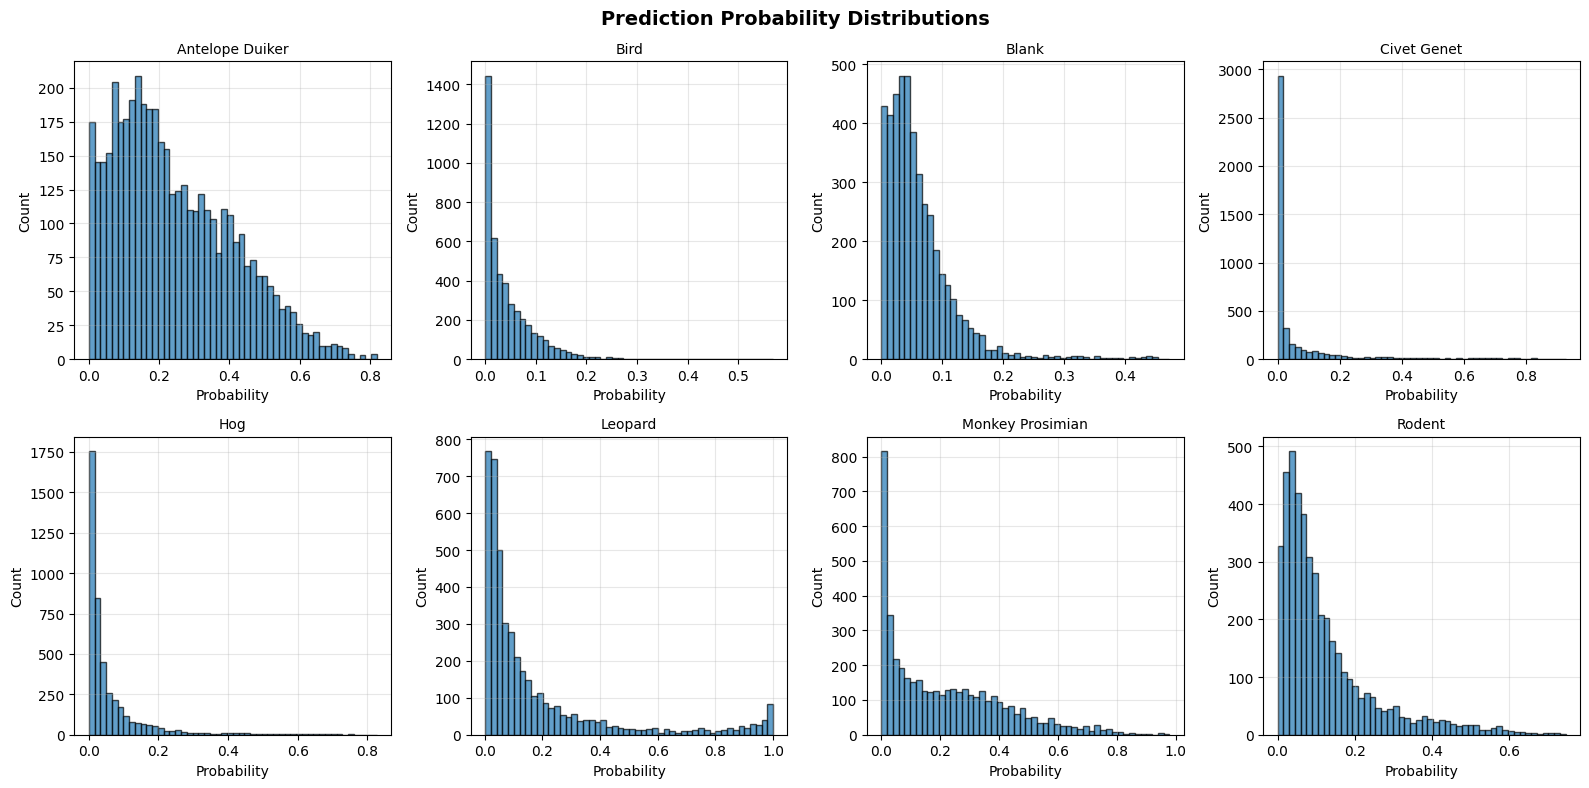

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_COLUMNS):
    axes[idx].hist(submission_df[class_name], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(class_name.replace('_', ' ').title(), fontsize=10)
    axes[idx].set_xlabel('Probability')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Prediction Probability Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'visualizations' / 'prediction_distributions.png', dpi=300)
plt.show()

In [13]:
# Save submission
SUBMISSION_PATH = OUTPUT_DIR / "submission.csv"
submission_df.to_csv(SUBMISSION_PATH, index=False)

print(f" Submission saved to: {SUBMISSION_PATH}")
print(f"   Size: {SUBMISSION_PATH.stat().st_size / 1024:.1f} KB")
print(f"   Rows: {len(submission_df)}")
print(f"   Columns: {len(submission_df.columns)}")

# Show sample
print("\n Sample submission (first 5 rows):")
display(submission_df.head())

print("\n Sample submission (last 5 rows):")
display(submission_df.tail())

 Submission saved to: outputs/submission.csv
   Size: 440.1 KB
   Rows: 4464
   Columns: 9

 Sample submission (first 5 rows):


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.021531,0.001420,0.025111,0.831887,0.012882,0.029937,0.001459,0.075773
1,ZJ016489,0.490976,0.010221,0.021238,0.004270,0.057012,0.041395,0.252599,0.122290
2,ZJ016490,0.603275,0.003062,0.058545,0.086709,0.054814,0.021288,0.094183,0.078124
3,ZJ016491,0.003049,0.000268,0.001632,0.001011,0.004418,0.986715,0.001307,0.001600
4,ZJ016492,0.387639,0.040864,0.014033,0.004398,0.003852,0.005060,0.517902,0.026253



 Sample submission (last 5 rows):


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
4459,ZJ020947,0.225647,0.138542,0.113489,0.003577,0.041071,0.124338,0.296996,0.056338
4460,ZJ020948,0.404381,0.045491,0.030294,0.007167,0.013659,0.217365,0.232580,0.049064
4461,ZJ020949,0.089949,0.000924,0.006705,0.512413,0.171093,0.031738,0.003092,0.184086
4462,ZJ020950,0.310766,0.156427,0.052335,0.004069,0.003947,0.027743,0.351183,0.093530
4463,ZJ020951,0.039397,0.003128,0.004751,0.000061,0.002853,0.846496,0.095120,0.008193


In [14]:
# TTA for better accuracy (takes 3-5x longer)

def get_tta_transforms(img_size=224):
    """Multiple transforms for TTA"""
    transforms_list = [
        # Original
        A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]),
        # Horizontal flip
        A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]),
        # Brightness adjusted
        A.Compose([
            A.Resize(img_size, img_size),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]),
    ]
    return transforms_list

def generate_tta_predictions(model, test_df, tta_transforms, device):
    """Generate predictions with TTA"""
    
    all_tta_predictions = []
    
    for transform_idx, transform in enumerate(tta_transforms):
        print(f"TTA {transform_idx + 1}/{len(tta_transforms)}...")
        
        # Create dataset with this transform
        dataset = TestDataset(test_df, DATA_DIR, transform)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, 
                          num_workers=4, pin_memory=True)
        
        # Generate predictions
        predictions, _ = generate_predictions(model, loader, device)
        all_tta_predictions.append(predictions)
    
    # Average predictions
    avg_predictions = np.mean(all_tta_predictions, axis=0)
    return avg_predictions

# Uncomment to use TTA (takes longer but improves accuracy)
# print("Generating predictions with TTA...")
# tta_transforms = get_tta_transforms(IMG_SIZE)
# tta_predictions = generate_tta_predictions(model, test_df, tta_transforms, DEVICE)
# 
# # Create TTA submission
# submission_tta_df = pd.DataFrame(tta_predictions, columns=CLASS_COLUMNS)
# submission_tta_df.insert(0, 'id', image_ids)
# submission_tta_df = postprocess_predictions(submission_tta_df)
# 
# # Save TTA submission
# submission_tta_df.to_csv(OUTPUT_DIR / "submission_tta.csv", index=False)
# print(f" TTA submission saved to: {OUTPUT_DIR / 'submission_tta.csv'}")

In [15]:
print("="*80)
print("INFERENCE COMPLETE!")
print("="*80)

print(f"\n Generated Files:")
print(f"   • Submission: {SUBMISSION_PATH}")
print(f"   • Predictions: {len(submission_df)} images")

print(f"\n Prediction Summary:")
total = len(submission_df)
for class_name in CLASS_COLUMNS:
    count = (submission_df[CLASS_COLUMNS].idxmax(axis=1) == class_name).sum()
    pct = count / total * 100
    print(f"   {class_name:20s}: {count:4d} ({pct:5.1f}%)")

INFERENCE COMPLETE!

 Generated Files:
   • Submission: outputs/submission.csv
   • Predictions: 4464 images

 Prediction Summary:
   antelope_duiker     : 1359 ( 30.4%)
   bird                :   14 (  0.3%)
   blank               :   65 (  1.5%)
   civet_genet         :  331 (  7.4%)
   hog                 :  179 (  4.0%)
   leopard             :  805 ( 18.0%)
   monkey_prosimian    : 1269 ( 28.4%)
   rodent              :  442 (  9.9%)
